In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
from utils import generate_dataset, ImplicitDataset, TestDataset, SliceDataset, OutsideMeshSDFDataset
import numpy as np
from sdf import *
import math

@sdf3
def gyroid(w = 3.14159, t=0):
    def f(p):
        q = w*p
        x, y, z = (q[:, i] for i in range(3))
        return (np.cos(x)*np.sin(y) + np.cos(y)*np.sin(z) + np.cos(z)*np.sin(x) - t)
    return f

In [13]:
generate_dataset(box(1.0) & gyroid(w=math.pi*4, t=0), N_train=40*40*40, N_test=1e6, name='box_1f0_gyroid_4pi', save_dir='../datasets')

Saved file at ../datasets\box_1f0_gyroid_4pi.stl
ImplicitDataset (64000 points)
SliceDataset (10000 points)
UniformMeshSDFDataset (1000000 points)
RandomMeshSDFDataset (1000000 points)
OutsideMeshSDFDataset (1000000 points)


In [14]:
name = 'box_1f0_gyroid_4pi'
train = ImplicitDataset.from_file(f'../datasets/{name}_train.npz')
test = TestDataset(f'../datasets/{name}_test.npz')
slice_dataset = SliceDataset.from_file(f'../datasets/{name}_slice.npz')

In [15]:
print(train)
print(test)
print(slice_dataset)
print(test.outside.points.shape)

ImplicitDataset (64000 points)
TestDataset (1000000 points, 1000000 points, 1000000 points)
SliceDataset (10000 points)
(1000000, 3)


In [22]:
np.einsum('ij,ij->i', np.array([[1,0,3], [1,2,3]]), np.array([[1,2,3],[1,1,1]]))

array([10,  6])

40


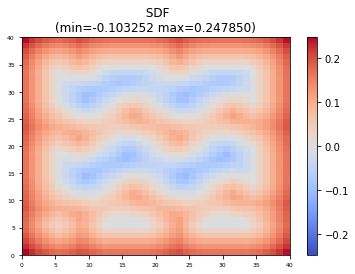

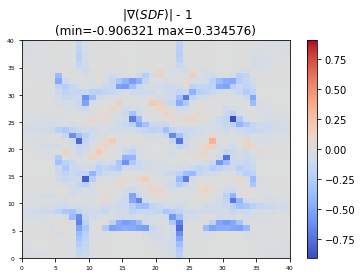

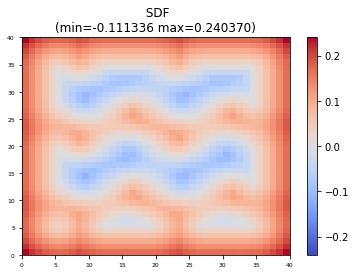

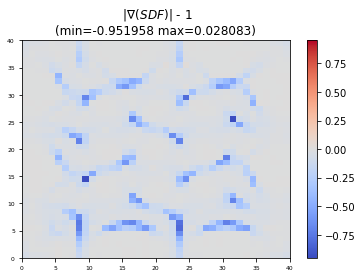

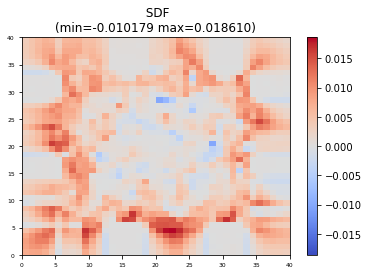

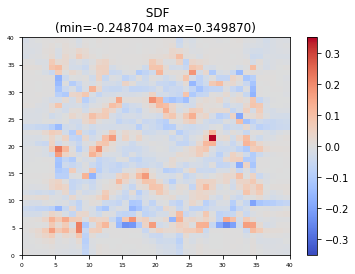

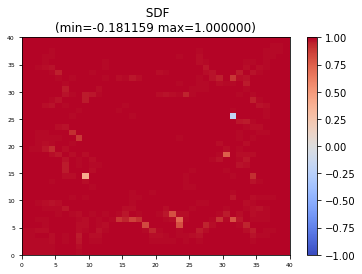

[]

In [30]:
ndim = round(train.sdfs.shape[0]**(1/3))
print(ndim)
points = train.points.reshape((ndim, ndim, ndim, 3))
sdfs  = train.sdfs.reshape((ndim, ndim, ndim))
true_sdfs  = train.true_sdfs.reshape((ndim, ndim, ndim))

dx = points[1,1,1,:] - points[0,0,0,:]
#grad = np.linalg.norm(np.array(np.gradient(sdfs, *dx)), axis=0)
grad = train.grads.reshape((ndim, ndim, ndim, 3))
norm_grad = np.linalg.norm(grad, axis=3)

true_grad = train.true_grads.reshape((ndim, ndim, ndim, 3))
norm_true_grad = np.linalg.norm(true_grad, axis=3)

cosine_similarity = np.einsum('ij,ij->i', train.grads, train.true_grads).reshape((ndim,ndim,ndim)) / norm_grad / norm_true_grad

slice_z = 20
from utils.visualizer import SDFVisualize
visualizer = SDFVisualize()
visualizer._plot(sdfs[:, :, slice_z], norm_grad[:, :, slice_z])
visualizer._plot(true_sdfs[:, :, slice_z], norm_true_grad[:, :, slice_z])
visualizer._plot(sdfs[:, :, slice_z] - true_sdfs[:, :, slice_z])
visualizer._plot(norm_grad[:, :, slice_z] - norm_true_grad[:, :, slice_z])
visualizer._plot(cosine_similarity[:,:,slice_z])


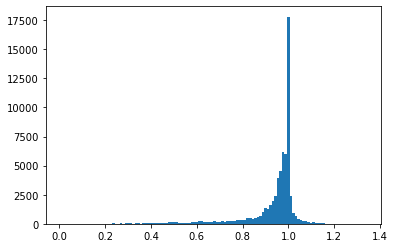

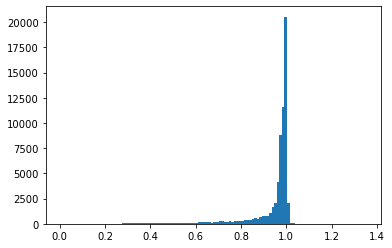

In [18]:
import matplotlib.pyplot as plt
_norm_grad = norm_grad.reshape((ndim**3,))
_norm_true_grad = norm_true_grad.reshape((ndim**3,))
plt.hist(_norm_grad, bins=120)
plt.show()
plt.hist(_norm_true_grad, bins=120)
plt.show()